In [189]:
import bisect
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api
import statsmodels.regression.linear_model

try:
    import sklearn.metrics
except ModuleNotFoundError:
    !pip install sklearn
    import sklearn.metrics
    
import sqlalchemy
    
%matplotlib inline

In [238]:
large_fig_size = [8, 6]
plt.rcParams['figure.figsize'] = large_fig_size

print(plt.style.available)
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-deep')
# plt.style.use('seaborn-dark')


['bmh', 'fivethirtyeight', 'seaborn-deep', 'fast', 'seaborn-muted', 'ggplot', 'classic', 'seaborn-white', 'seaborn-darkgrid', 'seaborn-whitegrid', 'seaborn-dark', 'dark_background', 'seaborn-notebook', 'seaborn-ticks', 'Solarize_Light2', 'seaborn-talk', 'seaborn-bright', 'seaborn-colorblind', 'grayscale', 'seaborn', 'seaborn-paper', 'seaborn-poster', '_classic_test', 'seaborn-dark-palette', 'seaborn-pastel']


In [239]:
FILEPATH = '../data/comparison_results_osrm_mapbox_gmpas_full.csv'
df = pd.read_csv(FILEPATH)
print(df.shape)
df.head(5)

(15637, 8)


,mapbox_duration,point_latitude,point_id,closest_time,gmaps_duration,closest_provider.latitude,closest_provider.longitude,point_longitude
0,32.690000,34.511397,2424932,42.395000,34.983333,34.639930,-120.445101,-120.502091
1,16.338333,37.041940,2425551,19.526667,16.733333,36.962863,-122.044151,-122.222050
2,12.305000,35.781638,2425725,16.275000,18.966667,35.742418,-120.876719,-120.948027
3,13.500000,37.315224,2425535,15.146667,13.683333,37.457759,-122.430278,-122.403565
4,37.155000,35.606589,2425805,34.471667,16.033333,35.555077,-120.723092,-120.853441


In [240]:
df.dropna(inplace=True)
print(df.shape)
df.columns

(15583, 8)


Index(['mapbox_duration', 'point_latitude', 'point_id', 'closest_time',
       'gmaps_duration', 'closest_provider.latitude',
       'closest_provider.longitude', 'point_longitude'],
      dtype='object')

In [241]:
def regress(independent_vars=['closest_time'], dependent_var='gmaps_duration'):
    X = df[independent_vars].values
    X = statsmodels.api.add_constant(X)
    y = df[dependent_var].values
    lm = statsmodels.regression.linear_model.OLS(y, X).fit()
    print(lm.summary())

regress(independent_vars=['closest_time'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                 8.268e+04
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        20:40:33   Log-Likelihood:                -54540.
No. Observations:               15583   AIC:                         1.091e+05
Df Residuals:                   15581   BIC:                         1.091e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1545      0.091     23.647      0.0

In [242]:
regress(independent_vars=['mapbox_duration'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                 6.215e+04
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        20:40:33   Log-Likelihood:                -56365.
No. Observations:               15583   AIC:                         1.127e+05
Df Residuals:                   15581   BIC:                         1.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9268      0.099     39.749      0.0

In [243]:
df['absolute_error'] = (df['gmaps_duration'] - df['closest_time']).apply(abs)
df['relative_error'] = ((df['gmaps_duration'] - df['closest_time']) / df['gmaps_duration']).apply(abs)

In [244]:
df['absolute_error'].describe()

count    15583.000000
mean         5.303210
std          8.502718
min          0.000000
25%          1.073333
50%          2.705000
75%          6.376667
max        156.325000
Name: absolute_error, dtype: float64

In [245]:
df['relative_error'].describe()

count    15583.000000
mean         0.270626
std          0.272541
min          0.000000
25%          0.100776
50%          0.212869
75%          0.365252
max          8.003237
Name: relative_error, dtype: float64

In [246]:
def plot_errors(df, error_col):
    fig, axs = plt.subplots(2, 2, figsize=(20,14))
    
    df[error_col].hist(bins=20, ax=axs[0][0])
    sns.distplot(
        df[error_col],
        ax=axs[1][0],
        hist_kws=dict(cumulative=True),
        kde_kws=dict(cumulative=True)
    )
    
    # Zoom-in on the first part of the chart
    start = math.floor(np.min(df[error_col]))
    stop = math.ceil(np.max(df[error_col]) / 4)
    step = float((stop - start) / 20)
    _range = np.arange(start, stop, step)
    
    ax = axs[0][1]
    ax.set_xlim(start, stop)
    ax.set_xticks(np.arange(start, stop, step))
    df[error_col].hist(bins=_range, ax=ax, density=True)


    ax = axs[1][1]
    ax.set_xlim(start, stop)
    ax.set_xticks(_range)

    sns.distplot(
        df[error_col],
        bins=_range,
        hist_kws=dict(cumulative=True),
        kde_kws=dict(cumulative=True),
        ax=ax
    )

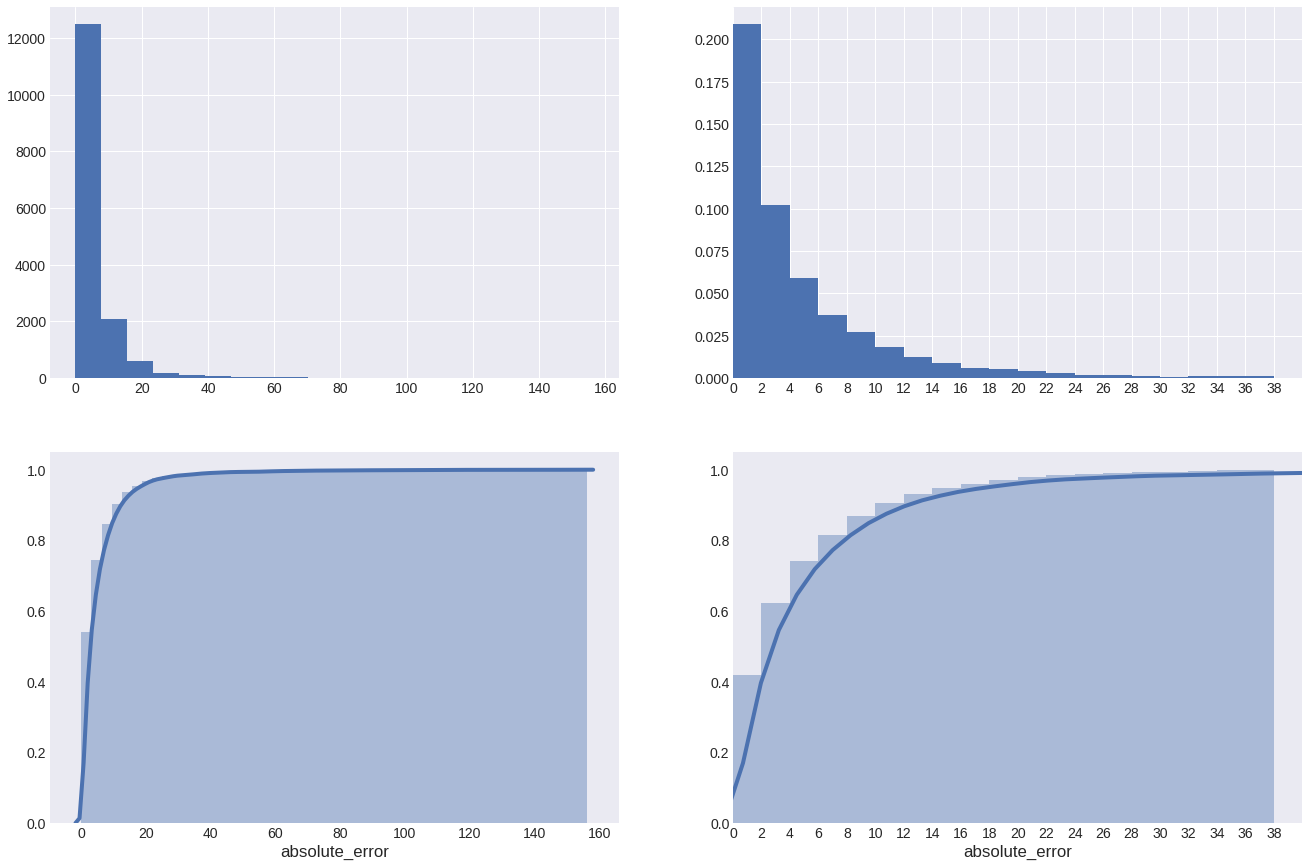

In [247]:
plot_errors(df, 'absolute_error')

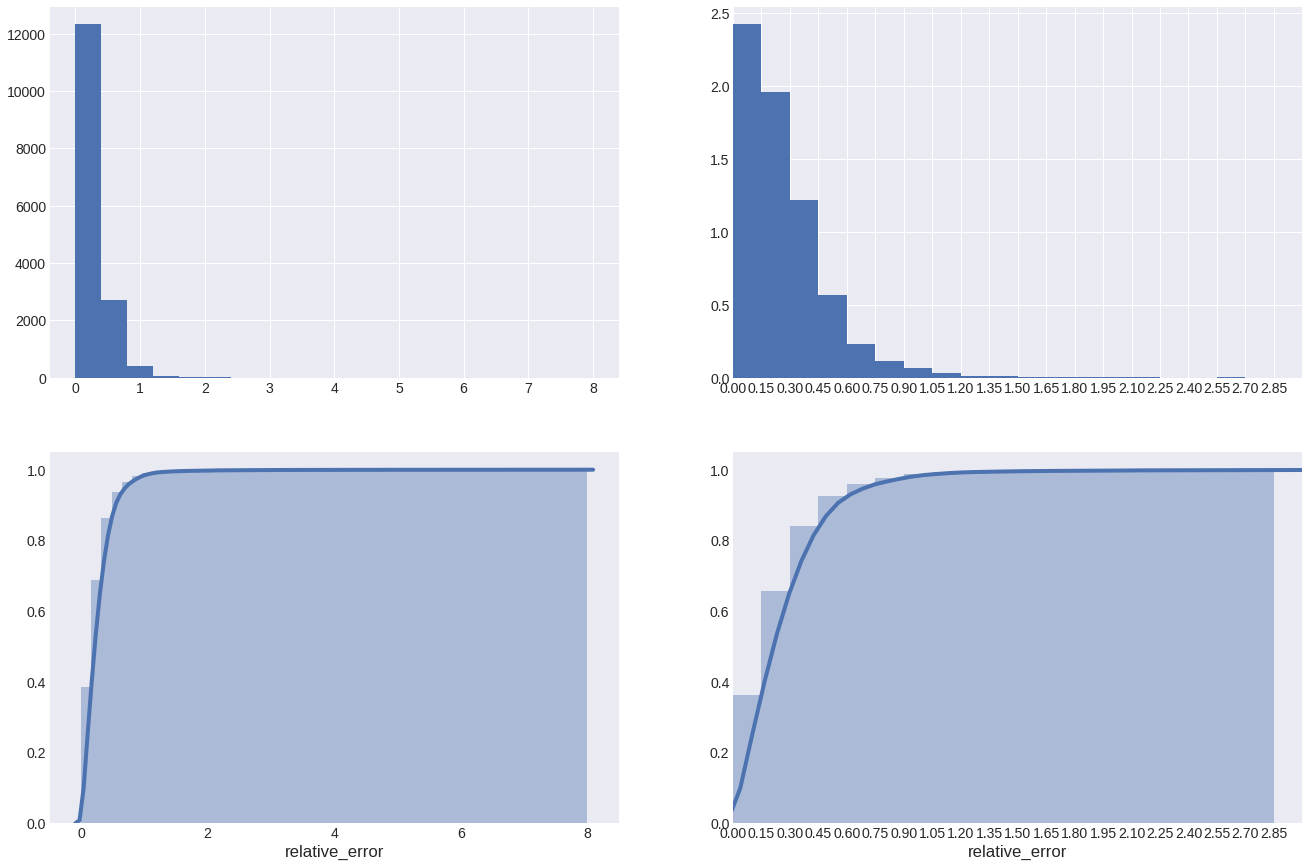

In [248]:
plot_errors(df, 'relative_error')

In [249]:
def inverse_cdf(cdf, x, errors):
    return errors[bisect.bisect(cdf, x)]

In [250]:
df = df.sort_values('absolute_error')
df['count'] = [1] * len(df)
df['running_count'] = df['count'].cumsum()
df['cdf'] = df['running_count']/np.max(df['running_count'])

In [251]:
cutoffs = np.hstack((
    np.array([0.05]),
    np.arange(0.1, 1.0, 0.1),
    np.array([0.975, 0.99, 0.999, 0.9999, 0.9999999])
))

errors = df['absolute_error'].values
cdf = df['cdf'].values
values = np.array([inverse_cdf(cdf, x, errors) for x in cutoffs])

for cutoff, value in zip(cutoffs, values):
    print(str(cutoff)[:9] + ' , ' + str(float(value))[:6])

0.05 , 0.2116
0.1 , 0.4199
0.2 , 0.8466
0.3000000 , 1.3183
0.4 , 1.9116
0.5 , 2.7049
0.6 , 3.7916
0.7000000 , 5.3499
0.8 , 7.7650
0.9 , 12.229
0.975 , 24.485
0.99 , 38.586
0.999 , 102.83
0.9999 , 155.37
0.9999999 , 156.32


### Gloss:

50% of points have a discrepancy of 2.7 minutes or less.

Roughly two-thirds of all points have a discrepancy of 5 minutes or less.

10% of points have a discrepancy of 12 minutes or more.

In [252]:
df = df.sort_values('relative_error')
df['count'] = [1] * len(df)
df['running_count'] = df['count'].cumsum()
df['cdf'] = df['running_count']/np.max(df['running_count'])

errors = df['relative_error'].values
cdf = df['cdf'].values
values = np.array([inverse_cdf(cdf, x, errors) for x in cutoffs])

for cutoff, value in zip(cutoffs, values):
    print(str(cutoff)[:9] + ' , ' + str(float(value))[:6])

0.05 , 0.0206
0.1 , 0.0404
0.2 , 0.0803
0.3000000 , 0.1220
0.4 , 0.1656
0.5 , 0.2128
0.6 , 0.2659
0.7000000 , 0.3281
0.8 , 0.4088
0.9 , 0.5377
0.975 , 0.8828
0.99 , 1.1275
0.999 , 2.7459
0.9999 , 5.7022
0.9999999 , 8.0032


### Gloss:

50% of points have a discrepancy of 21% or less.

70% of all points have a discrepancy of 33% or less.

10% of points have a discrepancy of 53% or more.

## Classification Error

In [253]:
bins = [0, 25, 35, float('inf')]
bin_names_map = {
    '[0.0, 25.0)': 0,
    '[25.0, 35.0)': 1,
    '[35.0, inf)': 2
}
df['osrm_bin'] = pd.cut(df['closest_time'], bins, right=False).apply(lambda x: bin_names_map[str(x)])
df['google_bin'] = pd.cut(df['gmaps_duration'], bins, right=False).apply(lambda x: bin_names_map[str(x)])
df['mapbox_bin'] = pd.cut(df['mapbox_duration'], bins, right=False).apply(lambda x: bin_names_map[str(x)])

In [254]:
y_true = df['google_bin'].values
y_pred = df['osrm_bin'].values

conf = confusion_matrix(y_true, y_pred, [0, 1, 2]) / len(df) * 100
print(conf)
# Rows are "true bins", columns are predicted bins. 
# So 7.4% were in 0-25 according to Google but 25-35 according to OSRM.

[[65.1992556   7.431175    1.5144709 ]
 [ 0.77006995  4.18404672  4.72951293]
 [ 0.42353847  0.77006995 14.97786049]]


In [255]:
print('{} percent of points were assigned identical bins.'.format(np.trace(conf)))

84.36116280562152 percent of points were assigned identical bins.


In [256]:
y_true = df['google_bin'].values
y_pred = df['mapbox_bin'].values

conf = sklearn.metrics.confusion_matrix(y_true, y_pred, [0, 1, 2]) / len(df) * 100
print(conf)
# Rows are "true bins", columns are predicted bins. 
# So 7.4% were in 0-25 according to Google but 25-35 according to OSRM.

[[66.93833023  5.45466213  1.75190913]
 [ 0.90483219  5.10171341  3.677084  ]
 [ 0.36578323  0.84065969 14.96502599]]


In [257]:
print('{} percent of points were assigned identical bins.'.format(np.trace(conf)))

87.00506962715781 percent of points were assigned identical bins.


In [258]:
df['osrm_under_30'] = df['closest_time'] < 30
df['google_under_30'] = df['gmaps_duration'] < 30
df['mapbox_under_30'] = df['mapbox_duration'] < 30

def summarize(y_true, y_pred, target_names):
    if len(target_names) == 2:
        print('Accuracy: {}'.format(100*sklearn.metrics.accuracy_score(y_true, y_pred)))
        print('Precision: {}'.format(100*sklearn.metrics.precision_score(y_true, y_pred)))
        print('Recall: {}'.format(100*sklearn.metrics.recall_score(y_true, y_pred)))
        print('ROC AUC: {}'.format(100*sklearn.metrics.roc_auc_score(y_true, y_pred)))
        print('\n')
    print('Classification report:')
    print(sklearn.metrics.classification_report(y_true, y_pred, target_names=target_names))

y_true = df['google_under_30'].values
y_pred = df['osrm_under_30'].values

summarize(y_true, y_pred, target_names=['inadequate', 'adequate'])
print(sklearn.metrics.confusion_matrix(y_true, y_pred, [1, 0]) / len(df) * 100)

Accuracy: 91.49072707437593
Precision: 98.403559277676
Recall: 90.79932383482252
ROC AUC: 92.5040922971581


Classification report:
             precision    recall  f1-score   support

 inadequate       0.72      0.94      0.82      3160
   adequate       0.98      0.91      0.94     12423

avg / total       0.93      0.91      0.92     15583

[[72.38657511  7.33491625]
 [ 1.17435667 19.10415196]]


In [259]:
y_pred = df['mapbox_under_30'].values
summarize(y_true, y_pred, target_names=['inadequate', 'adequate'])
print(sklearn.metrics.confusion_matrix(y_true, y_pred, [1, 0]) / len(df) * 100)

Accuracy: 92.70358724250785
Precision: 98.38792659921111
Recall: 92.36094341141431
ROC AUC: 93.20578816140338


Classification report:
             precision    recall  f1-score   support

 inadequate       0.76      0.94      0.84      3160
   adequate       0.98      0.92      0.95     12423

avg / total       0.94      0.93      0.93     15583

[[73.63152153  6.08996984]
 [ 1.20644292 19.07206571]]


### Notes

* Precision: Proportion of samples marked as belonging to a category that actually belonged to that category.
* Recall: Proportion of samples that actually belong to a category that are marked as such.
* F1: Mix of the above.

The recall for inadequate points of 0.94 means that 94% of the time that a point was actually inadequate (according to Google), MapBox agreed that the point was inadequate. That's pretty good!

The 0.98 precision in the adequate category means that 98% of points that MapBox marked as being adequate were validated by Google. The 0.76 precision for the inadequate category shows that one quarter of the time MapBox marked a point as being inadequate, the point was actually adequate according to Google. This confirms our expectations that Google generally gives shorter drive times, possibly due to better or more complete road networks.

MapBox appears to have a very slight edge on OSRM, but not by as much as I would have expected.

Note that by using a slightly different prediction process we could shift the balance of these numbers. For example, we could use a cutoff of 35 minutes for MapBox to mark a point as inadequate. This would result in fewer points being mislabeled as inadequate, thereby increasing the precision for that class. On the other hand, this would come at a cost: we might falsely mark some inadequate points as adequate (reducing the recall for the inadequate class). Alternatively, we could use a cutoff below 30 minutes, moving the numbers in the opposite directions.

Evaluating such tradeoffs would depend on the goals of the end-user. Maybe it's very important that every inadequate point gets marked as inadequate (i.e., false negatives must be avoided). But maybe it's more important that every point marked as inadequate is truly inadequate -- if there was a significant cost to responding to inadequacies, users wouldn't want to spend the time chasing down illusory ones.

## County Analysis

Do OSRM and MapBox perform equally well across all counties, or are there some problem counties where they do particularly poorly?

In [260]:
import collections
import os

# Use PROD!
engine = sqlalchemy.create_engine(os.getenv('POSTGRES_URL'), pool_size=20, max_overflow=0)
rows = engine.execute('''
    SELECT s.service_area_id, p.id 
    FROM representative_points p 
    JOIN service_areas s
    ON (s.service_area_id = p.service_area_id)
    '''
).fetchall()

In [261]:
point_id_to_service_area_map = {
    row['id']: row['service_area_id']
    for row in rows
}

df['service_area_id'] = df['point_id'].apply(lambda x: point_id_to_service_area_map[x])    

In [262]:
g = df.groupby('service_area_id')
g['relative_error'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
service_area_id,,,,,,,,
ca_glenn_county_00000,208.0,0.433446,0.255702,0.025655,0.267827,0.399838,0.534997,1.464513
ca_fresno_county_00000,892.0,0.387697,0.346527,0.000000,0.155944,0.303345,0.518269,5.057531
ca_san_francisco_county_00000,24.0,0.381199,0.198555,0.031915,0.235805,0.374640,0.517751,0.830515
ca_orange_county_00000,248.0,0.355691,0.460190,0.000585,0.148192,0.283229,0.429788,4.490925
ca_colusa_county_00000,193.0,0.332979,0.175068,0.031367,0.223641,0.293825,0.403923,0.993939
ca_kern_county_00000,1082.0,0.325903,0.270009,0.000198,0.148076,0.277459,0.433194,2.678344
ca_merced_county_00000,393.0,0.324940,0.286495,0.000257,0.126356,0.272836,0.434104,2.142945
ca_kings_county_00000,189.0,0.317972,0.227245,0.003736,0.155479,0.272026,0.422599,1.064025
ca_madera_county_00000,438.0,0.316411,0.244675,0.000439,0.133025,0.262283,0.434582,1.614405


### Error vs. Distance

Maybe larger (absolute, relative) errors tend to occur when the time itself is already large? 

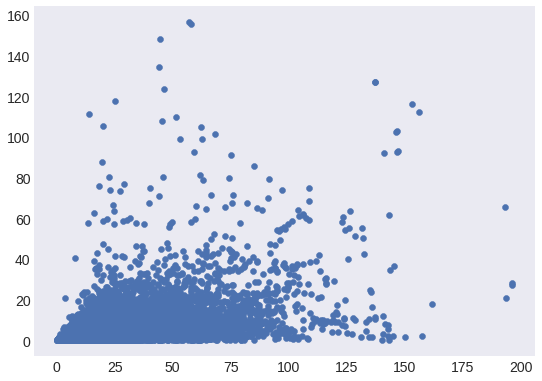

In [263]:
plt.scatter(df['gmaps_duration'].values, df['absolute_error'].values)

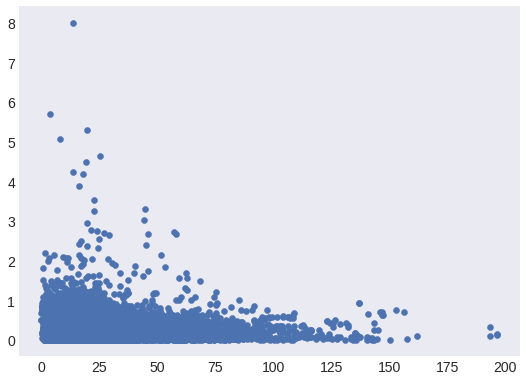

In [264]:
plt.scatter(df['gmaps_duration'].values, df['relative_error'].values)

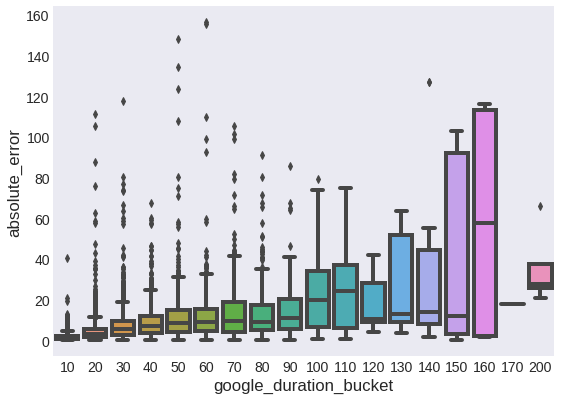

In [265]:
df['google_duration_bucket'] = df['gmaps_duration'].apply(lambda x: 10*math.ceil(x / 10)).astype(int)
sns.boxplot(x='google_duration_bucket', y='absolute_error', data=df)

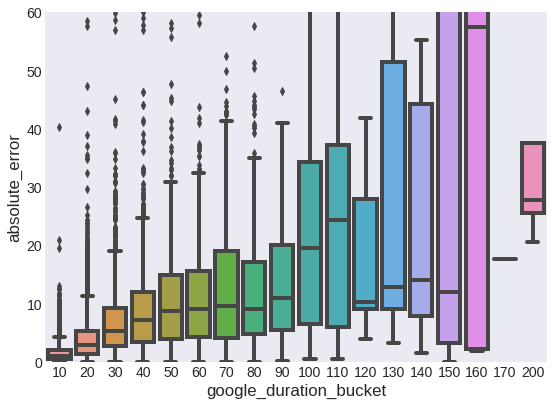

In [266]:
plt.ylim(0.0, 60.0)
sns.boxplot(x='google_duration_bucket', y='absolute_error', data=df)

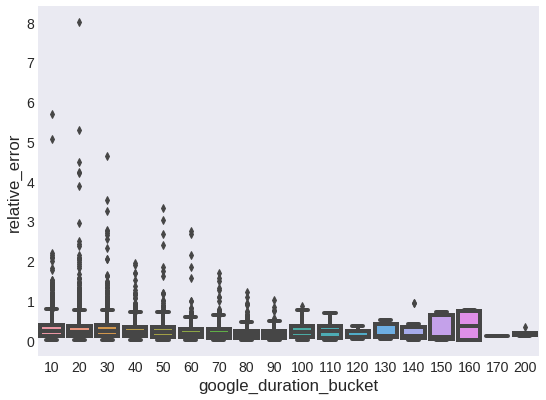

In [267]:
sns.boxplot(x='google_duration_bucket', y='relative_error', data=df)

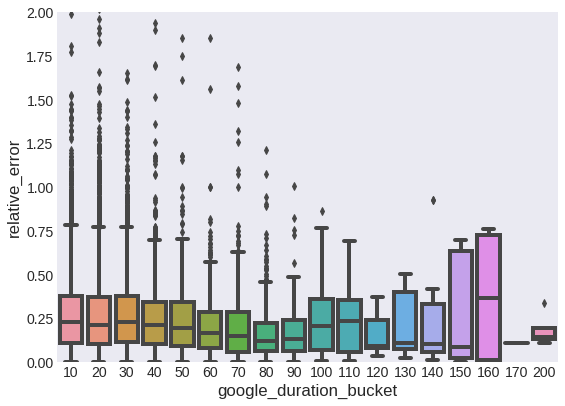

In [268]:
plt.ylim(0.0, 2.0)
sns.boxplot(x='google_duration_bucket', y='relative_error', data=df)

## Comments

Relative errors were fairly constant across all values of Google duration.

### OSRM vs. Mapbox

So far we have been looking at OSRM/Mapbox vs. Google. Now let's compare OSRM to Mapbox directly.

In [270]:
y_true = df['mapbox_under_30'].values
y_pred = df['osrm_under_30'].values

summarize(y_true, y_pred, target_names=['inadequate', 'adequate'])
print(sklearn.metrics.confusion_matrix(y_true, y_pred, [1, 0]) / len(df) * 100)

Accuracy: 94.21805814028107
Precision: 96.9379743522638
Recall: 95.28382781684103
ROC AUC: 93.16601490306475


Classification report:
             precision    recall  f1-score   support

 inadequate       0.87      0.91      0.89      3921
   adequate       0.97      0.95      0.96     11662

avg / total       0.94      0.94      0.94     15583

[[71.30847719  3.52948726]
 [ 2.2524546  22.90958095]]


In [279]:
y_true = df['mapbox_bin'].values
y_pred = df['osrm_bin'].values

conf = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[0, 1, 2]) / len(df) * 100
print(conf)
print('Accuracy: {}'.format(np.trace(conf)))

[[64.14682667  3.88243599  0.17968299]
 [ 2.02785086  6.53917731  2.83000706]
 [ 0.21818649  1.96367837 18.21215427]]
Accuracy: 88.89815824937432


In [287]:
y_true = df['google_bin'].values
y_pred = df['mapbox_bin'].values

conf = sklearn.metrics.confusion_matrix(y_true, y_pred, [0, 1, 2]) / len(df) * 100
print(conf)
print('Accuracy: {}'.format(np.trace(conf)))

[[66.93833023  5.45466213  1.75190913]
 [ 0.90483219  5.10171341  3.677084  ]
 [ 0.36578323  0.84065969 14.96502599]]
Accuracy: 87.00506962715781


In [286]:
y_true = df['google_bin'].values
y_pred = df['osrm_bin'].values

conf = sklearn.metrics.confusion_matrix(y_true, y_pred, [0, 1, 2]) / len(df) * 100
print(conf)
print('Accuracy: {}'.format(np.trace(conf)))

[[65.1992556   7.431175    1.5144709 ]
 [ 0.77006995  4.18404672  4.72951293]
 [ 0.42353847  0.77006995 14.97786049]]
Accuracy: 84.36116280562152


The upper-right and lower-left entries are of particular interest. 

The upper-right entry is the fraction of samples with the "true" label >25 but the predicted label >35. 

The lower-left entry is the fraction of samples with the "true" label >35 but the predicted label <25.

Note how these numbers are comparable using Mapbox or OSRM vs. Google. For Mapbox vs. OSRM, these numbers are exceedingly small, suggesting that they are very close. Let's run a regression:

In [289]:
regress(independent_vars=['closest_time'], dependent_var='mapbox_duration')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 1.295e+05
Date:                Fri, 16 Mar 2018   Prob (F-statistic):               0.00
Time:                        00:50:50   Log-Likelihood:                -55415.
No. Observations:               15583   AIC:                         1.108e+05
Df Residuals:                   15581   BIC:                         1.109e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4358      0.096     -4.522      0.0

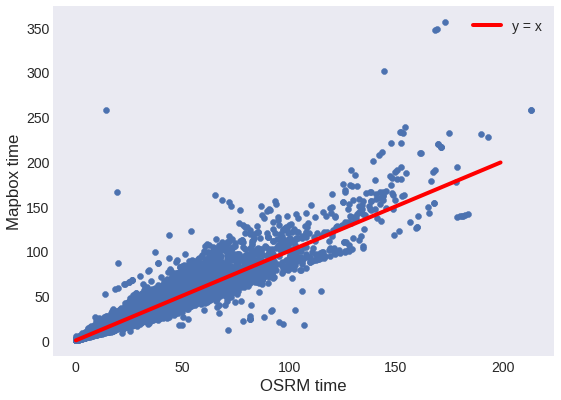

In [299]:
plt.xlabel('OSRM time');
plt.ylabel('Mapbox time');
plt.scatter(df['closest_time'].values, df['mapbox_duration'].values)
plt.plot(np.arange(0, 200, 1), np.arange(0, 200, 1), color='r', label='y = x')
plt.legend()

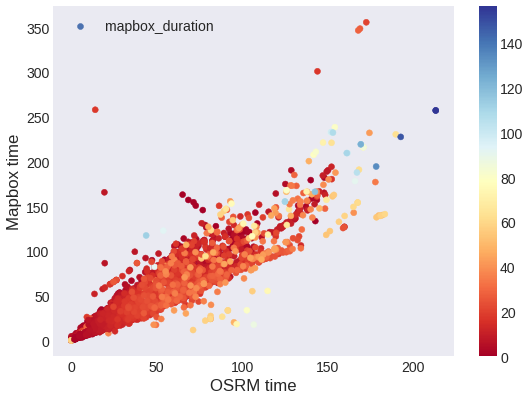

In [309]:
plt.xlabel('OSRM time');
plt.ylabel('Mapbox time');
sc = plt.scatter(df['closest_time'], y=df['mapbox_duration'], c=df['absolute_error'], cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar(sc)
plt.legend()

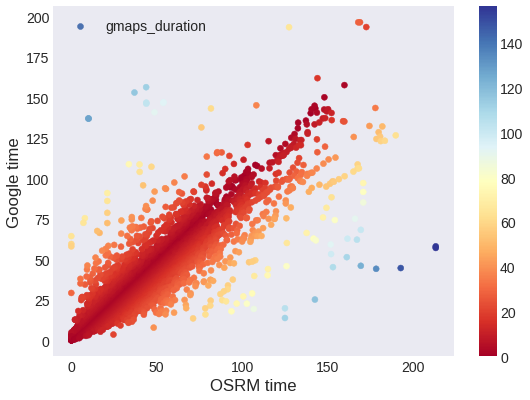

In [310]:
plt.xlabel('OSRM time');
plt.ylabel('Google time');
sc = plt.scatter(df['closest_time'], y=df['gmaps_duration'], c=df['absolute_error'], cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar(sc)
plt.legend()

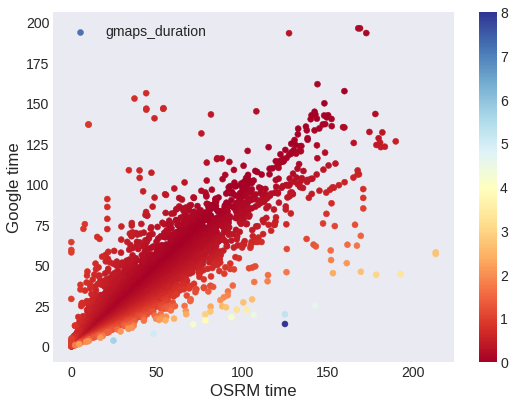

In [311]:
plt.xlabel('OSRM time');
plt.ylabel('Google time');
sc = plt.scatter(df['closest_time'], y=df['gmaps_duration'], c=df['relative_error'], cmap=plt.cm.get_cmap('RdYlBu'))
plt.colorbar(sc)
plt.legend()